# DS8 - DBSCAN assignment

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [25]:
n1 = 100
X1_x = (np.random.rand(n1)-2)*2
X1_y = np.random.rand(n1)+1

n2 = 100
X2_x = (np.random.rand(n2)+1)*2 
X2_y = np.random.rand(n2)+1

step = 0.01
X3_x = np.arange(-2, 2+step, step)
n3 = len(X3_x)
X3_y = (np.random.randn()/3-0.001)*X3_x**2 - 2 + np.random.randn(n3)/3

X1 = np.vstack([X1_x, X1_y])
X2 = np.vstack([X2_x, X2_y])
X3 = np.vstack([X3_x, X3_y])
X = np.hstack([X1, X2, X3]).T
X[:5, :]

array([[-3.16896671,  1.10362081],
       [-3.56468624,  1.14737778],
       [-3.89786797,  1.00955461],
       [-3.16509829,  1.32067596],
       [-3.66480546,  1.29687086]])

## 1. Determine good parameters to cluster $X$ with DBSCAN. Perform DBSCAN (use sklearn implementation) on the data and visualise the plot

In [26]:
X_scaled = StandardScaler().fit_transform(X)

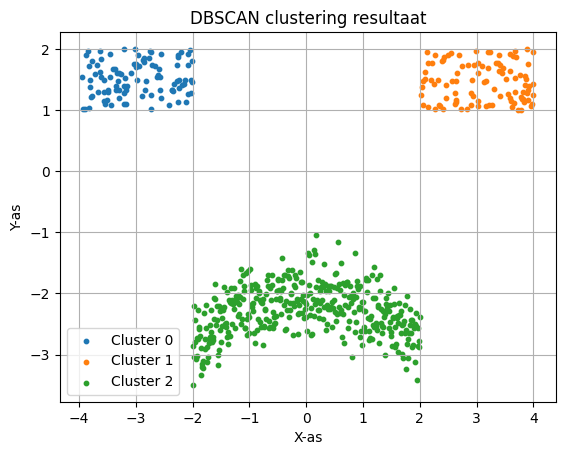

In [27]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

unique_labels = set(labels)

for label in unique_labels:
    mask = (labels == label)
    plt.scatter(X[mask, 0], X[mask, 1], s=10, label=f'Cluster {label}' if label != -1 else 'Noise')

plt.title('DBSCAN clustering resultaat')
plt.xlabel('X-as')
plt.ylabel('Y-as')
plt.legend()
plt.grid(True)
plt.show()


## 2. Write a DBSCAN implementation that clusters data from arbitrary dimension
For the following exercises, no for-loops are allowed. Unless stated otherwise. 

We define a couple of constants (recognizable by writing them in ALL CAPS). You can use these constants in- and outside of the function.

In [48]:
EPSILON = 0.7 # our value for epsilon
INDEX = np.arange(len(X)) # an array of all the indexes of X
NOISE = -1 # which value is used as the noise cluster
MIN_NEIGHBOURS = 4 # our value for n_min

We need to compute the distance between all the datapoints and a specific datapoint very often. That's why it is important to write a very fast distance function.

### 2.1 Make a function `dist(data: np.ndarray, p_index: int) -> np.ndarray` that outputs the Euclidean distance between all data points in $X$ and point $p = X_\text{p_index}$

In [49]:
def dist(data: np.ndarray, p_index: int) -> np.ndarray:
    p = data[p_index]
    diff = data - p
    return np.sqrt(np.sum(diff**2, axis=1))

Test the speed of your code with the following code block. Your function should run in less than 50µs.

In [30]:
%%timeit
# test your distance function
dist(X, 0)

8.32 μs ± 109 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


We also want to extract all the candidate neighbours for a certain point $p$. Remember, if a datapoint is already assigned to a cluster, it is not a neighbour anymore. That's why we are looking for candidates. 
### 2.2 Make a function `determine_neighbours(data: np.ndarray, p_index: int) -> candidates: np.ndarray` that outputs a boolean array `candidates` where $\text{candidates}_i = \text{True}$ if point with index $i$ is a potential neighbour of point $p$.
Also make sure that point $p$ is not assigned as a candidate neighbour of itself. 

In [50]:
def determine_neighbours(data: np.ndarray, p_index: int) -> np.ndarray:
    distances = dist(data, p_index)
    candidates = (distances <= EPSILON)
    candidates[p_index] = False
    return candidates

In [32]:
%%timeit
determine_neighbours(X, 0)

9.73 μs ± 93.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Your function should run in less than 100µs.

### 2.3 Make a function `find_neighbours(clusters: np.ndarray, data: np.ndarray, p_index: int) -> neighbours: np.ndarray` that outputs the neighbours of point $p$, where `clusters` is the array with cluster labels for each point. 

In [51]:
def find_neighbours(clusters: np.ndarray, data: np.ndarray, p_index: int) -> np.ndarray:
    distances = dist(data, p_index)
    unassigned = (clusters == NOISE)
    close_enough = (distances <= EPSILON)
    not_self = np.arange(len(data)) != p_index
    neighbours = unassigned & close_enough & not_self
    return neighbours

In [34]:
%%timeit
find_neighbours(np.zeros(len(X)), X, 0)

15.7 μs ± 136 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Your function should run in less than 150µs.

Now we are going to write the core part of the DBSCAN algorithm. You can use at most 1 for-loop for this function.
### 2.4 Make a function `assign_neighbours_to_cluster(clusters: np.ndarray, data: np.ndarray, p_index: int, c: int)` that modifies the array `clusters`. 
Make sure the function does the following steps
1. Check if p_index is already assigned to a cluster, if so return None
2. If not, change the cluster value of point `p_index` to `c`
3. Check if point $p$ has enough neighbours to assign those neighbours as well to cluster `c`
4. Recursively add the neighbours and their neighbours of point $p$ to cluster `c`. 

In [53]:
def assign_neighbours_to_cluster(clusters: np.ndarray, data: np.ndarray, p_index: int, c: int):
    if clusters[p_index] != NOISE:
        return None

    clusters[p_index] = c

    neighbours = find_neighbours(clusters, data, p_index)
    if np.sum(neighbours) < MIN_NEIGHBOURS:
        return None

    clusters[neighbours] = c
    to_check = np.where(neighbours)[0]

    i = 0
    while i < len(to_check):
        point = to_check[i]
        if clusters[point] == NOISE:
            clusters[point] = c
        new_neigh = find_neighbours(clusters, data, point)
        if np.sum(new_neigh) >= MIN_NEIGHBOURS:
            new_points = np.where(new_neigh & (clusters == NOISE))[0]
            clusters[new_points] = c
            to_check = np.concatenate([to_check, new_points])
        i += 1

In [36]:
%%timeit
assign_neighbours_to_cluster(np.zeros(len(X)), X, 0, 1)

547 ns ± 2.84 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Your function should run in less than 1ms.

## 2.5 Combine all these elements into a DBSCAN algorithm. You are allowed to use 1 for loop.
Compare your results from 1. 

In [54]:
def DBSCAN(data: np.ndarray) -> np.ndarray:
    clusters = np.full(len(data), NOISE)  # start: alles is noise
    current_cluster = 0

    for p_index in range(len(data)):
        if clusters[p_index] != NOISE:
            continue
        # Probeer een nieuw cluster te maken vanuit dit punt
        previous = clusters.copy()
        assign_neighbours_to_cluster(clusters, data, p_index, current_cluster)
        if not np.array_equal(clusters, previous):  # als het cluster groeide
            current_cluster += 1

    return clusters

In [38]:
%%timeit
clusters = DBSCAN(X)

6.36 ms ± 87.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Your code should run in less than 100ms

## 2.6 Check if your algorithm works on the following dataset. Visualise the cluster by using PCA. Make sure to first estimate the correct parameters.

In [55]:
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
X = make_blobs(n_samples = 100, n_features = 6)[0]

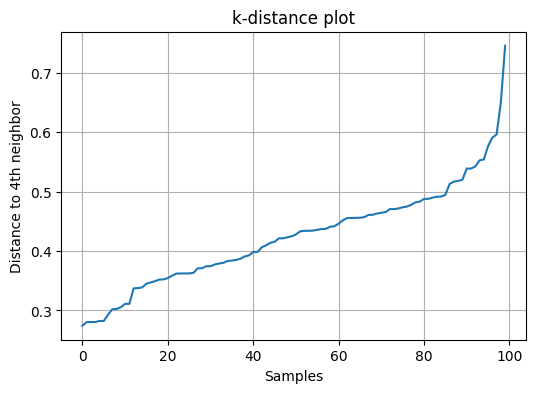

In [56]:
X_scaled = StandardScaler().fit_transform(X)


neigh = NearestNeighbors(n_neighbors=MIN_NEIGHBOURS)
nbrs = neigh.fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)

# Sorteer de afstanden van de MIN_NEIGHBOURS-de buur
k_distances = np.sort(distances[:, MIN_NEIGHBOURS - 1])

plt.figure(figsize=(6, 4))
plt.plot(k_distances)
plt.title("k-distance plot")
plt.xlabel("Samples")
plt.ylabel("Distance to {}th neighbor".format(MIN_NEIGHBOURS))
plt.grid(True)
plt.show()

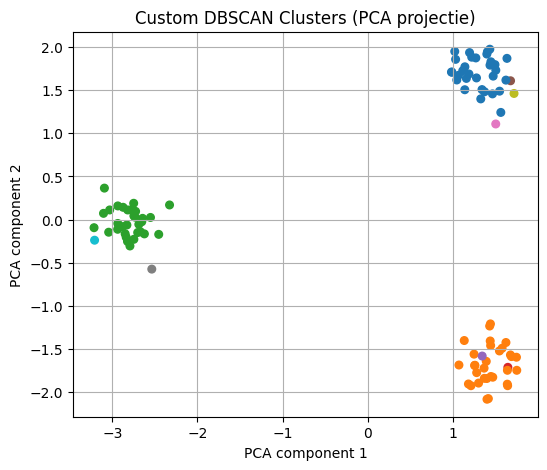

In [57]:
clusters = DBSCAN(X_scaled)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="tab10", s=30)
plt.title("Custom DBSCAN Clusters (PCA projectie)")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.grid(True)
plt.show()